# AIRBNB RENT PREDICTION MODEL
## by Daniel Banach

# Table Of Contents  
>## 1. Introduction.
>## 2. Helper Functions and Initial Setup.
>## 3. Cleaning Data.
>## 4. Minor Adjustments
>>###### (What remained from Analysis in original notebook). 
>## 5. Data Creation.  
>## 6. Feature Engineering.
>## 7. Last Adjustments.  
>## 8. Modeling.  
>## 9. Hyperparameter Tunning.


# 1 - Intro

I'll work with the famous Airbnb Seattle dataset, this dataset contains two files:
1. calendar.csv
2. listings.csv  

The purpose of this project is to predict the price of Seattle Airbnb rentals based on the data provided and also using external data from YELP API.



# 2 - Helper Functions and Initial Setup

In [2]:
#check python version
!python -V

Python 3.7.12


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import pickle
from geopy.distance import geodesic
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')
import requests
import json

In [4]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV

In [5]:
# YELP_DATA = if we'll create data from Yelp Api (True) or we'll load it from a file (False).
YELP_DATA = False


In [6]:
calendar = pd.read_csv('calendar.csv')
listings = pd.read_csv('listings.csv')

# added this option so i could scroll through all the columns with head() or sample() methods
pd.set_option('max_columns',None)

In [7]:
def change_to_boolean(df,cols):
    '''
    function that receives dataframe df and columns where to change 't' to 1 and 'f' to 0
    cols = list of columns
    '''
    for col in cols:
        df.loc[:,col] = df[col].apply(lambda s: 1 if s=='t' else 0)

def change_from_dollar(df,cols):
    '''
    function that receives a dataframe df and columns where to change from price string format "$1,000.00" to float
    '''
    
    for col in cols:
        df.loc[:,col] = df[col].apply(lambda s: s if s is np.nan else float(s.replace(',','')[1:]))
        
def change_from_percentage(df, cols):
    '''
    function that receives a dataframe df and columns where to change from string format '34%' to float 34
    '''
    for col in cols:
        df.loc[:,col] = df[col].apply(lambda s: s if s is np.nan else float(s.replace('%','')))
        
def transform_and_return(df,features,model):
    '''
    Function that receives a dataframe, its features and an already fitted transformer and applies the
    transformer and returns the output as a dataframe
    '''
    
    df =model.transform(df)
    df = pd.DataFrame(df,columns=features)
    df.reset_index(drop=True,inplace=True)
    return df

    
def agregate_categories(df1,df2,df3,cols):
    '''
    function that agregates categories in variables that have lots of categories
    
    '''

    for col in cols:

        value_c = df1[col].value_counts()
        vals = value_c.index[:5]
        df1[col] =df1[col].where(df1[col].isin(vals), 'other')
        df2[col] =df2[col].where(df2[col].isin(vals), 'other')
        df3[col] =df3[col].where(df3[col].isin(vals), 'other')

def dataframe_with_dummies(df,dummies,encoder,features):
    """
    function that receives df dataframe with the independent features and does OHE transformation with
    the already fitted encoder "encoder" and returns a dataframe with all of the OHE features, the rest of the features
    of the df dataframe 

    """
    df_dummies = pd.DataFrame(data = encoder.transform(df[dummies]).toarray(),columns = encoder.get_feature_names(dummies))                        
    df = pd.concat([df[features], df_dummies], axis=1)
    df.columns = features + list(encoder.get_feature_names(dummies))
    return df       

def plot_feature_importance(importance,names,model_type,num_features):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df = fi_df.iloc[:num_features,:num_features]
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.show()
    return list(fi_df['feature_names'])

def get_best_features(importance,names,model_type,num_features):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df = fi_df.iloc[:num_features,:num_features]
    

    return list(fi_df['feature_names'])
    
def distance_latlon(point1, point2):
    '''
    Function that receives the latitude and longitude of 2 points (point1 and point2 are tuples) and returns  
    the distance in kilometers
    '''
    
    return geodesic(point1, point2).km

def model_output(y_val,y_preds):
    
    R2 = r2_score(y_val,y_preds)
    MSE = mean_squared_error(y_val,y_preds)
    MAE = mean_absolute_error(y_val,y_preds)
    MAPE = mean_absolute_percentage_error(y_val,y_preds)
    print('R^2: ',R2)
    print('MSE: ',MSE)
    print('MAE: ',MAE)
    print('MAPE: ',MAPE)
    
    
# helper functions to retrive new data to add
def get_data_to_add(listing,avg_per_period,summer, weekend):
    '''
    Function that receives listing dataframe and with the information in the avg_per_period data frame, converts the  
    data in listing to that of the period of summer and weekend that could be 1 or 0 each.  
    Then returns the new data to add to the dataset
    '''
    
    features = list(listing.columns)
    my_listing = listing.copy()
    my_listing.drop(columns=['price'],inplace=True)
    my_listing.summer = summer
    my_listing.weekend = weekend

    add_listing = avg_per_period[(avg_per_period.summer==summer)&(avg_per_period.weekend==weekend)]
    add_listing.drop(columns=['summer','weekend','avg_price'],inplace=True)

    my_listing =  my_listing.merge(add_listing,left_on='id', right_on='listing_id', how='left')
    my_listing = my_listing[~my_listing.price.isna()]
    my_listing = my_listing[features]
    return my_listing

def get_data_all_period(listing, avg_per_period):
    '''
    Function that for one listing dataframe returns the listing, having added information from same listings in
    different periods
    '''
    my_listing= listing.copy()
    for pair in [[1,1],[1,0],[0,1]]:
        my_listing = pd.concat([my_listing,get_data_to_add(listing,avg_per_period,pair[0],pair[1])],ignore_index=True)
    
    return my_listing


In [8]:
# to impute later on
mostf_filler = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent'))
])

mean_filler = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='mean'))
])

# 3 - Cleaning the data

## Deleting

In [9]:

to_delete = ['name','transit','street','neighbourhood_cleansed','picture_url','neighborhood_overview', 'space','host_about',
             'thumbnail_url','host_picture_url','description','medium_url','host_thumbnail_url','xl_picture_url','notes',
             'summary','neighbourhood_group_cleansed','host_url','listing_url','first_review',
             'calendar_last_scraped','last_review','host_name','calendar_updated','state','host_id','host_location',
             'scrape_id','square_feet','weekly_price','monthly_price','license','experiences_offered','city','market',
             'smart_location','country_code','country','requires_license','jurisdiction_names', 'security_deposit',
             'cleaning_fee','has_availability','host_acceptance_rate','host_total_listings_count']
listings.drop(columns=to_delete,inplace=True)


## Changing data type

In [10]:
#first i'll change features that have values 't' and 'f' to 1 and 0
to_boolean = ['host_is_superhost','host_has_profile_pic','host_identity_verified','is_location_exact',
             'instant_bookable','require_guest_profile_picture','require_guest_phone_verification']
change_to_boolean(listings,to_boolean)

In [11]:
# change features that have % to float
change_from_percentage(listings,['host_response_rate'])

In [12]:
#change features that have format $1000,00 to float
change_from_dollar(listings,['price','extra_people'])

## Fixing problems with data in BATHROOMS AND BEDROOMS  


In [13]:
#first we'll change the value of the bathrooms where also bedrooms is 0
my_index = listings[(listings.bathrooms==0)&(listings.bedrooms==0)].index
listings.loc[my_index,'bathrooms'] = listings[(listings.bathrooms==0)&(listings.bedrooms==0)].bathrooms.apply(lambda x: np.nan if x ==0 else x)

#now we'll change all of the values where bedrooms are 0
my_index = listings[(listings.bedrooms==0)].index
listings.loc[my_index,'bedrooms'] = listings[(listings.bedrooms==0)].bedrooms.apply(lambda x: np.nan if x ==0 else x)


## Dealining with nan's 


In [14]:
#there are features that makes sense to fill 'NA' or the like. These are features that
#i plan to use those afterwards for feature creation, i'll just impute an auxiliar value for now to be able
#to process the data 
to_fill_NA = ['host_neighbourhood','neighbourhood']

for col in to_fill_NA:
    listings[col].fillna('NA',inplace=True)


In [15]:
#there are 2 rows that they dont have info about the host so since there are so few instead of imputing something
#i'll just drop them
listings = listings[~listings.host_since.isna()]

#i'll also drop rows with nan zipcode since there are so little nan rows and i dont want to use later on some demographic data
#that could be mistaken 
listings = listings[~listings.zipcode.isna()]
#also eliminate mistaken zipcode value
listings = listings[~(listings.zipcode=='99\n98122')]

listings.reset_index(drop=True,inplace=True)


## Train test split  
In order that there would be no data lekeage i'll split the data before imputing values

In [16]:
listings_train_val, listings_test = train_test_split(listings, test_size=.2,random_state=12)
listings_train, listings_val = train_test_split(listings_train_val, test_size=.2,random_state=12)


In [17]:
#features to fill the nans with mean 

fill_with_mean = ['host_response_rate','review_scores_rating','review_scores_accuracy',
                 'review_scores_cleanliness','review_scores_checkin','review_scores_communication',
                 'review_scores_location','review_scores_value','reviews_per_month']

#features to fill the nans with most frequent 
fill_with_most_frequent = ['host_response_time','bathrooms','bedrooms','beds','property_type']

In [18]:
the_rest = list(set(listings.columns) - set(fill_with_mean)- set(fill_with_most_frequent))
features = fill_with_most_frequent +fill_with_mean +the_rest

In [19]:
listings_train = listings_train[features]
listings_val = listings_val[features]
listings_test = listings_test[features]

In [20]:
transformers = ColumnTransformer([
            ('mostf', mostf_filler, fill_with_most_frequent),
            ('mean',mean_filler,fill_with_mean),
            ('the_rest','passthrough',the_rest)
    ])

model = transformers.fit(listings_train)
listings_train = transform_and_return(listings_train,features,model)
listings_val = transform_and_return(listings_val,features,model)
listings_test = transform_and_return(listings_test,features,model)

In [22]:
# change data type tu numeric if possible
for df in [listings_train,listings_val,listings_test]:
    for col in listings_train.columns:
        try:
            for df in [listings_train,listings_val,listings_test]:
                df.loc[:,col] = pd.to_numeric(df[col])
        except:
            pass
        

## 3.2 - **Calendar DataFrame**

In [23]:
#changing values in 'available' from 't' and 'f' to 1,0
change_to_boolean(calendar,['available'])

# changing type of 'date' from object to datetime. (i'll need this later on to manipulate this feature)
calendar['date']= pd.to_datetime(calendar['date'])

#change format from price
change_from_dollar(calendar,['price'])

In [24]:
avg_price_per_id = calendar.groupby(calendar.listing_id).mean()
avg_price_per_id.reset_index(level=0, inplace=True)
avg_price_per_id = avg_price_per_id[['listing_id','price']]
avg_price_per_id.columns = ['listing_id','avg_price']


In [25]:
ids_to_delete = list(avg_price_per_id[avg_price_per_id.avg_price.isna()].listing_id)
calendar = calendar[~calendar.listing_id.isin(ids_to_delete)]


In [26]:
# add avg_price to calendar df
calendar = calendar.merge(avg_price_per_id, on='listing_id', how='left')


# change value of price feature if it's nan
calendar.loc[:,'price'] = calendar.apply(lambda row: row['price'] if not np.isnan(row['price']) else row['avg_price'] ,axis=1)
calendar.drop(columns=['avg_price'],inplace=True)


# 4 - Minor Adjustments  
##### After deleting the analysis it seems they are out of place, but if you see the jupyter notebook with the full analysis this is the right place.

### 4.1.1 - Price Distribution

In [28]:
# i'll eliminate the rows that are below and above 3 times the std of price (not so many rows).
#i'll only do this on the train set
mean_price = listings_train.price.mean()
std_price = listings_train.price.std()
min_price = mean_price-3*std_price
max_price = mean_price+3*std_price
line_d =listings_train.shape[0] -listings_train[(listings_train.price>=min_price)&(listings_train.price<=max_price)].shape[0]
print(f'{line_d} rows deleted')
listings_train =  listings_train[(listings_train.price>=min_price)&(listings_train.price<=max_price)]

41 rows deleted


In [29]:
# change the order of the features to see price at the end
rest = list(set(listings_train.columns) - set(['price']))
features = rest + ['price']
listings_train =  listings_train[features]
listings_val =  listings_val[features]
listings_test =  listings_test[features]


In [30]:

right_df =calendar.available.groupby(calendar['listing_id']).apply(lambda x: x.sum()/x.count()).reset_index(level=0)
right_df.columns=['id','occupancy']
right_df.head()

listings_train = listings_train.merge(right_df, on='id', how='left')
listings_val = listings_val.merge(right_df, on='id', how='left')
listings_test = listings_test.merge(right_df, on='id', how='left')
features = features +['occupancy']
# Fill Na in new feature with mean
for df in [listings_train,listings_val,listings_test]:
    df.fillna(listings_train.occupancy.mean(),inplace=True)


# 5 - Data Creation

In [34]:
#calendar dataframe
#we'll add some features to the calendar dataframe
calendar['day_of_week'] = pd.DatetimeIndex(calendar.date).dayofweek
calendar['month'] = pd.DatetimeIndex(calendar.date).month
calendar['week'] = pd.DatetimeIndex(calendar.date).week
calendar['weekend'] = calendar['day_of_week'].apply(lambda x: 1 if x>=5 else 0) 
calendar['summer'] = calendar['week'].apply(lambda x: 1 if ((x>=23) & (x<=34)) else 0) 

In [35]:
#we'll create features of 'summer', 'weekend'
for df in [listings_train,listings_val, listings_test]:
    df['weekend'] = 0
    df['summer'] = 0

In [36]:
#create dataframe with the price to create new data
df_avg_per_id_period = pd.DataFrame(calendar.groupby(['listing_id','summer','weekend']).price.mean()).reset_index(level=[0,1,2])


#create dataframe to have the average price in all the combinations (summer=[0,1], weekend =[0,1]) to check if the data is real
# meaning that it's highly unlikely that the price would be the same in every mommnent so a fast way to filter  
#data that we imputed because it was unavailable it is by filtering listings that have same price than the average
check_real_data = df_avg_per_id_period.groupby(df_avg_per_id_period.listing_id).price.mean().reset_index(level=0)
check_real_data.columns = ['listing_id','avg_price']

# merge the data to have a new column in order to see the rows that represent real data and filtering that
df_avg_per_id_period = df_avg_per_id_period.merge(check_real_data,on='listing_id',how='left')
df_avg_per_id_period = df_avg_per_id_period[df_avg_per_id_period.price!=df_avg_per_id_period.avg_price]


In [37]:
listings_train = get_data_all_period(listings_train,df_avg_per_id_period)
listings_val = get_data_all_period(listings_val,df_avg_per_id_period)
listings_test = get_data_all_period(listings_test,df_avg_per_id_period)

# 

# 6 - Feature Eng.


## 6.1 - Number of confirmations

In [38]:
listings_train.loc[:,'num_conf'] = listings_train.host_verifications.apply(lambda s: s.count(',')+1)
listings_val.loc[:,'num_conf'] = listings_val.host_verifications.apply(lambda s: s.count(',')+1)
listings_test.loc[:,'num_conf'] = listings_test.host_verifications.apply(lambda s: s.count(',')+1)


## 6.2 - Years of host being active

In [39]:
NOW =2016
listings_train.loc[:,'years_host'] = listings_train.host_since.apply(lambda x:(NOW - int(x[:4])))
listings_val.loc[:,'years_host'] = listings_val.host_since.apply(lambda x:(NOW - int(x[:4])))
listings_test.loc[:,'years_host'] = listings_test.host_since.apply(lambda x:(NOW - int(x[:4])))

## 6.3 - Same Neighbourhood

I want to use the features 'host_neighbourhood','neighbourhood' to create a new feature that is 1 if they are in the same  
neighbourhood or not. This makes sense since that adds more value because the host is more available to do things.

In [40]:
listings_train['same_neighbourhood'] =(listings_train.host_neighbourhood ==listings_train.neighbourhood)
listings_train.loc[:,'same_neighbourhood'] = listings_train.same_neighbourhood.apply(lambda x: 1 if x==True else 0)
listings_val['same_neighbourhood'] =(listings_val.host_neighbourhood ==listings_val.neighbourhood)
listings_val.loc[:,'same_neighbourhood'] = listings_val.same_neighbourhood.apply(lambda x: 1 if x==True else 0)
listings_test['same_neighbourhood'] =(listings_test.host_neighbourhood ==listings_test.neighbourhood)
listings_test.loc[:,'same_neighbourhood'] = listings_test.same_neighbourhood.apply(lambda x: 1 if x==True else 0)

## 6.4 - Binary features from Amenities

We'll create many binary features

In [41]:
for df in [listings_train,listings_val, listings_test]:
    df.loc[:,'has_ac'] = df.amenities.apply(lambda s: 1 if 'conditioning' in s.lower() else 0)
    df.loc[:,'has_internet'] = df.amenities.apply(lambda s: 1 if 'internet' in s.lower() else 0)
    df.loc[:,'has_pool'] = df.amenities.apply(lambda s: 1 if 'pool' in s.lower() else 0)
    df.loc[:,'has_tv'] = df.amenities.apply(lambda s: 1 if 'tv' in s.lower() else 0)
    df.loc[:,'smoking_allowed'] = df.amenities.apply(lambda s: 1 if 'smoking' in s.lower() else 0)
    df.loc[:,'washer'] = df.amenities.apply(lambda s: 1 if 'washer' in s.lower() else 0)
    df.loc[:,'smoke_detector'] = df.amenities.apply(lambda s: 1 if 'detector' in s.lower() else 0)
    df.loc[:,'pet_allowed'] = df.amenities.apply(lambda s: 1 if 'pet' in s.lower() else 0)
    df.loc[:,'kitchen'] = df.amenities.apply(lambda s: 1 if 'kitchen' in s.lower() else 0)
    df.loc[:,'iron'] = df.amenities.apply(lambda s: 1 if 'iron' in s.lower() else 0)
    df.loc[:,'fireplace'] = df.amenities.apply(lambda s: 1 if 'fireplace' in s.lower() else 0)
    df.loc[:,'hot_tub'] = df.amenities.apply(lambda s: 1 if 'tub' in s.lower() else 0)
    df.loc[:,'heating'] = df.amenities.apply(lambda s: 1 if 'heating' in s.lower() else 0)
    df.loc[:,'gym'] = df.amenities.apply(lambda s: 1 if 'gym' in s.lower() else 0)
    df.loc[:,'parking'] = df.amenities.apply(lambda s: 1 if 'parking' in s.lower() else 0)
    df.loc[:,'elevator'] = df.amenities.apply(lambda s: 1 if 'elevator' in s.lower() else 0)
    df.loc[:,'doorman'] = df.amenities.apply(lambda s: 1 if 'doorman' in s.lower() else 0)
    df.loc[:,'breakfast'] = df.amenities.apply(lambda s: 1 if 'breakfast' in s.lower() else 0)    

In [42]:
amenities_list = ['has_ac','has_internet','has_pool','has_tv','smoking_allowed','washer','smoke_detector',
                 'pet_allowed','kitchen','iron','fireplace','hot_tub','heating','gym','parking',
                 'elevator','doorman','breakfast']


## 6.5 - Listing within downtown or not

**is_downtown**  
It's values will be 1 if it's in the area and 0 if not.

In [43]:
# Checking the Yelp Api , the center of seattle has coordenates :'longitude': -122.3355, 'latitude': 47.6254.
min_lat = 47.60
max_lat = 47.66
min_lon = -122.40
max_lon = -122.275

for df in [listings_train,listings_val, listings_test]:
    df['is_downtown'] =((df.latitude >= min_lat) & (df.latitude <= max_lat)) &((df.longitude >= min_lon) & (df.longitude <= max_lon))
    df.loc[:,'is_downtown'] = df.is_downtown.apply(lambda s: 1 if s==True else 0)



## 6.6 - Distance of listing to downtown

I'll also create the feature **distance_to_downtown**.

In [44]:
CENTER_LAT = 47.6254
CENTER_LON = -122.3355
listings_train['distance_to_downtown'] =((listings_train.latitude - CENTER_LAT) ** 2 + (listings_train.longitude - CENTER_LON) ** 2)**(1/2)
listings_val['distance_to_downtown'] =((listings_val.latitude - CENTER_LAT) ** 2 + (listings_val.longitude - CENTER_LON) ** 2)**(1/2)
listings_test['distance_to_downtown'] =((listings_test.latitude - CENTER_LAT) ** 2 + (listings_test.longitude - CENTER_LON) ** 2)**(1/2)


## 6.7 - Adding from YELP API

### 6.7.1 - Creating new auxiliar feature

In [45]:
# i'll add a new feature that's really a copy of zipcode to use in the creation of features with Yelp API
listings_train['zipcode2'] = listings_train.zipcode
listings_val['zipcode2'] = listings_val.zipcode
listings_test['zipcode2'] = listings_test.zipcode


### 6.7.1 - Getting data from API

In [46]:
if YELP_DATA:


    api_key='B6FdYh1q4CLceKS84XrCQMxindMSIThCTT1jWphGoMbMrJAneCxV4D-jrmbxvdwBPrXhbUMHVWcdfC0YtiwaDb1pMEnJn8I4JUmF7w7i9NitlSu0FM4i1OUJRyO7YXYx'
    headers = {'Authorization': f'Bearer {api_key}'}
    url='https://api.yelp.com/v3/businesses/search'
    names = []
    ratings = []
    latitudes = []
    longitudes = []
    prices = []
    zip_codes = []

    # since i saved the data with this already changed i commented this code snippet

    offset = 0
    while offset <= 30000:
        params={'term':'Restaurants', 'location': 'seattle', 'limit': 50, 'radious':10000,'offset': offset}
        response = requests.get(url, params=params, headers=headers)
        data = response.json()
        n = 0
        while n < 50:
    #         print(n)
            try:
                restaurant = data['businesses'][n]

                #first create variable so in case one element is not there it will go to except

                price = restaurant['price']
                zipcode = restaurant['location']['zip_code']
                name = restaurant['name']
                rating = restaurant['rating']
                lat = restaurant['coordinates']['latitude']
                lon = restaurant['coordinates']['longitude']

                prices.append(price)
                zip_codes.append(zipcode)
                names.append(name)
                ratings.append(rating)
                latitudes.append(lat)
                longitudes.append(lon)
                n+=1
            except:
                ## some of the data gathered are not going to have the necessary information
                ## so we skip those 
                n+=1
        offset += 50

    yelpdata = pd.DataFrame({'name':names,'rating':ratings,'zipcode':zip_codes,'prices':prices,'lat':latitudes,
                             'lon':longitudes})
    # we'll drop duplicates just in case
    yelpdata = yelpdata.drop_duplicates(ignore_index=True)

    # we'll change the price from $,$$.. to 1,2..
    # since i saved the data with this already changed i commented this code snippet

    yelpdata.loc[:,'prices'] = yelpdata.prices.apply(lambda s:len(s))
    
else:
    with open("yelpdata.pkl", "rb") as input_file:
        yelpdata= pickle.load(input_file)

### 6.7.2 - Creation of rating and prices features.

In [48]:
# the easiest way to use this data is by grouping by zipcode and get the average rating and prices
rating_df = yelpdata.rating.groupby(yelpdata['zipcode']).mean().reset_index(level=0)
price_df = yelpdata.prices.groupby(yelpdata['zipcode']).mean().reset_index(level=0)

rating_price_df = rating_df.merge(price_df, on='zipcode')
rating_price_df.columns = ['code','avg_rating_per_zipcode','avg_prices_per_zipcode']
for df in [listings_train, listings_val, listings_test]:
    df.loc[:,'zipcode2'] = df.zipcode2.apply(lambda s: str(s))
#     df.loc[:,:] = df.merge(rating_price_df,left_on='zipcode2',right_on='zipcode',how='left')
listings_train= listings_train.merge(rating_price_df,left_on='zipcode2',right_on='code',how='left')
listings_val = listings_val.merge(rating_price_df,left_on='zipcode2',right_on='code',how='left')
listings_test = listings_test.merge(rating_price_df,left_on='zipcode2',right_on='code',how='left')

### 6.7.3 - Creation of new features based on restaurants within a specific radius of the property.

In [49]:
if YELP_DATA:

    RADIUS = 5

    ratings = [[],[],[]]
    prices = [[],[],[]]
    counts = [[],[],[]]

    for num,df in enumerate([listings_train,listings_val, listings_test]):
        for index,elem in (enumerate(list(df.zipcode))):
            point1 = (df.latitude[index],df.longitude[index])        
            my_data = yelpdata.copy()
            my_series = my_data.apply(lambda row: distance_latlon(point1,(row['lat'],row['lon'])),axis=1)
            my_series = my_series[my_series <RADIUS]
            my_index = my_series.index
            my_data = my_data.iloc[my_index]
            ratings[num].append(my_data.rating.mean())
            prices[num].append(my_data.prices.mean())
            counts[num].append(my_data.rating.count())
else:
    with open("ratings.pkl", "rb") as input_file:
        ratings= pickle.load(input_file)
    with open("prices.pkl", "rb") as input_file:
        prices= pickle.load(input_file)
    with open("counts.pkl", "rb") as input_file:
        counts= pickle.load(input_file)
    

       

In [ ]:
# # we'll save ratings, prices, and counts, so we won't have to run that code again since it takes time
# pickle.dump(ratings,open('ratings.pkl','wb'))
# pickle.dump(prices,open('prices.pkl','wb'))
# pickle.dump(counts,open('counts.pkl','wb'))

In [50]:
listings_train['avg_rating_radius'] = pd.Series(ratings[0])
listings_val['avg_rating_radius'] = pd.Series(ratings[1])
listings_test['avg_rating_radius'] = pd.Series(ratings[2])

listings_train['avg_prices_radius'] = pd.Series(prices[0])
listings_val['avg_prices_radius'] = pd.Series(prices[1])
listings_test['avg_prices_radius'] = pd.Series(prices[2])

listings_train['restaurants_radius'] = pd.Series(counts[0])
listings_val['restaurants_radius'] = pd.Series(counts[1])
listings_test['restaurants_radius'] = pd.Series(counts[2])

# 7 - **Last adjustments**  

## 7.1 - Bed Type

Bed type really has 1 value with a lot of data and not so much with different kinds of options (couch, futon...etc).  
I'll just change it to 1 or 0 depending if it is "Real bed" or not

In [51]:
listings_train.loc[:,'bed_type'] = listings_train.bed_type.apply(lambda s: 1 if s=='Real Bed' else 0)
listings_val.loc[:,'bed_type'] = listings_val.bed_type.apply(lambda s: 1 if s=='Real Bed' else 0)
listings_test.loc[:,'bed_type'] = listings_test.bed_type.apply(lambda s: 1 if s=='Real Bed' else 0)

## 7.2 **DELETE** features no longer useful

In [52]:
to_delete = ['host_verifications','host_since','host_neighbourhood','amenities','id','last_scraped',
            'zipcode2','code']

for df in [listings_train, listings_val, listings_test]:
    for col in to_delete:
        
        #deleting last_scraped, no longer useful
        df.drop(columns=[col],inplace=True)


## 7.3 - Inpute values in features created.  
In some of the features created there are nan values since during the merge (left_joins) some values on the left df were not  
in the right df.

In [54]:
for df in [listings_train, listings_val, listings_test]:
    for col in ['avg_rating_per_zipcode','avg_prices_per_zipcode','avg_rating_radius','avg_prices_radius']:
        df[col].fillna(listings_train[col].mean(),inplace=True)


## 7.4 - Change categories of features

In [55]:
# property_type change to apartment, house, other
#we see that the only categories with more than 5% are Apartment and house
display(listings_train.property_type.value_counts()[listings_train.property_type.value_counts()>listings_train.shape[0]*0.05])

# we'll change the data
for df in [listings_train, listings_val, listings_test]:
    df.loc[:,'property_type'] = df.property_type.apply(lambda s: s if ((s=='Apartment') or (s=='House')) else 'Other')

Apartment    3036
House        2645
Name: property_type, dtype: int64

In [56]:
# features with 2 many categories we'll aggragate features with not so many data into "other" category.
#this could be done more precise, but we'll keep only 5 categories including other  

aggregate = ['neighbourhood','zipcode']
agregate_categories(listings_train,listings_val, listings_test,aggregate)
listings_train.loc[:,'neighbourhood'] = listings_train.neighbourhood.apply(lambda s: s if s!='NA' else 'other')
listings_val.loc[:,'neighbourhood'] = listings_val.neighbourhood.apply(lambda s: s if s!='NA' else 'other')
listings_test.loc[:,'neighbourhood'] = listings_test.neighbourhood.apply(lambda s: s if s!='NA' else 'other')

In [57]:
#deal with ordinal features

host_resp_dict = {'a few days or more':1, 'within a day':2, 'within a few hours':3, 'within an hour':4}
listings_train.loc[:,'host_response_time'] = listings_train.host_response_time.apply(lambda x: host_resp_dict[x])
listings_val.loc[:,'host_response_time'] = listings_val.host_response_time.apply(lambda x: host_resp_dict[x])
listings_test.loc[:,'host_response_time'] = listings_test.host_response_time.apply(lambda x: host_resp_dict[x])

cancellation_dict = {'flexible':1, 'moderate':2, 'strict':3}
listings_train.loc[:,'cancellation_policy'] = listings_train.cancellation_policy.apply(lambda x: cancellation_dict[x])
listings_val.loc[:,'cancellation_policy'] = listings_val.cancellation_policy.apply(lambda x: cancellation_dict[x])
listings_test.loc[:,'cancellation_policy'] = listings_test.cancellation_policy.apply(lambda x: cancellation_dict[x])


## 7.5 - OneHotEncoding

In [58]:
for df in [listings_train, listings_val, listings_test]:
    
    #making sure all elements in zipcode are strings so there wont be an error doing onehotencoder
    df.loc[:,'zipcode'] = df.zipcode.apply(lambda s: str(s))

In [59]:
#onehotencoding the nominal features  
enc = OneHotEncoder(handle_unknown='ignore')
nominal = ['property_type','neighbourhood','zipcode','room_type']
enc.fit(listings_train[nominal])
features_ = list(set(listings_train.columns) - set(nominal))
listings_train =  dataframe_with_dummies(listings_train,nominal,enc,features_)
listings_val =  dataframe_with_dummies(listings_val,nominal,enc,features_)
listings_test =  dataframe_with_dummies(listings_test,nominal,enc,features_)

# 8 - Modelling.


## 8.1 - Preparation code.

In [60]:
#need to split in X,y
X_train = listings_train.loc[:,listings_train.columns!='price']
y_train = listings_train.price
y_train=y_train.astype('float')

X_val = listings_val.loc[:,listings_val.columns!='price']
y_val = listings_val.price
y_val=y_val.astype('float')

X_test = listings_test.loc[:,listings_test.columns!='price']
y_test = listings_test.price
y_test=y_test.astype('float')


In [61]:
new_features = amenities_list + ['occupancy', 'weekend', 'summer', 'num_conf' ,'years_host' ,  'same_neighbourhood',
                                 'is_downtown' ,'distance_to_downtown', 'avg_rating_per_zipcode' ,
                                 'avg_prices_per_zipcode', 'avg_rating_radius', 'avg_prices_radius', 'restaurants_radius']
old_features = list(set(X_train.columns) - set(new_features))


In [62]:
X_train = X_train[old_features+new_features]
X_val = X_val[old_features+new_features]
X_test = X_test[old_features+new_features]

## 8.2 Baseline Model

First i'll run a random forest, but just to get the best 20 features that the model gives as an output. I'll do this in 
order to choose the features and then run some model with those features to define our baseline model and then see the efect of all the features and of the created features.

In [63]:
simple_rf = RandomForestRegressor()
simple_rf.fit(X_train[old_features],y_train)
best_20_features = get_best_features(simple_rf.feature_importances_,X_train[old_features].columns,'RF',20)

In [64]:
ridge = Ridge()
ridge.fit(X_train[best_20_features],y_train)
y_preds = ridge.predict(X_val[best_20_features])
print('Output of Metrics for Ridge model with best 20 features.')
print('(without created features)\n')
model_output(y_val,y_preds)

Output of Metrics for Ridge model with best 20 features.
(without created features)

R^2:  0.5902045028338274
MSE:  3954.4823163436995
MAE:  41.55899066632523
MAPE:  0.3080817958982964


In [65]:
ridge = Ridge()
ridge.fit(X_train[old_features],y_train)
y_preds = ridge.predict(X_val[old_features])
print('Output of Metrics for Ridge model.')
print('(without created features)\n')
model_output(y_val,y_preds)

Output of Metrics for Ridge model.
(without created features)

R^2:  0.6325097045242489
MSE:  3546.2416862464706
MAE:  39.07662572184812
MAPE:  0.28264961661001314


In [66]:
ridge = Ridge()
ridge.fit(X_train[old_features+new_features],y_train)
y_preds = ridge.predict(X_val[old_features+new_features])
print('Output of Metrics for Ridge model.')
print('(with created features)\n')
model_output(y_val,y_preds)

Output of Metrics for Ridge model.
(with created features)

R^2:  0.673856050075522
MSE:  3147.2539143978106
MAE:  37.00786960651886
MAPE:  0.2755664690584724


We can see how the features add value to the model. 

## 8.3 - Random Forest

### 8.3.1 - RF with best 20 features

In [67]:
rf1 = RandomForestRegressor()
rf1.fit(X_train[best_20_features],y_train)
y_preds = rf1.predict(X_val[best_20_features])
print('Output of Metrics for Random Forest model with best 20 features.')
print('(without created features)\n')
model_output(y_val,y_preds)

Output of Metrics for Random Forest model with best 20 features.
(without created features)

R^2:  0.6473182333730092
MSE:  3403.3409812156838
MAE:  37.41824677713015
MAPE:  0.2653750767310685


### 8.3.2 - RF with all features (not including created features)

In [68]:
rf2 = RandomForestRegressor()
rf2.fit(X_train[old_features],y_train)
y_preds = rf2.predict(X_val[old_features])
print('Output of Metrics for Random Forest.')
print('(without created features)\n')
model_output(y_val,y_preds)

Output of Metrics for Random Forest.
(without created features)

R^2:  0.6309963428449552
MSE:  3560.8454631068407
MAE:  37.87678930164325
MAPE:  0.2668800264979816


Interesting that the RF did worst with all of the original features. That could be because of overfitting.

### 8.3.3 - RF including created features.

In [69]:
rf3 = RandomForestRegressor()
rf3.fit(X_train[old_features + new_features],y_train)
y_preds = rf3.predict(X_val[old_features + new_features])
print('Output of Metrics for Random Forest.')
print('(with created features)\n')
model_output(y_val,y_preds)

Output of Metrics for Random Forest.
(with created features)

R^2:  0.705613676605062
MSE:  2840.796246149716
MAE:  33.275344003667605
MAPE:  0.23916638363257878


Here we see an incredible improvement with the created features using RF.  

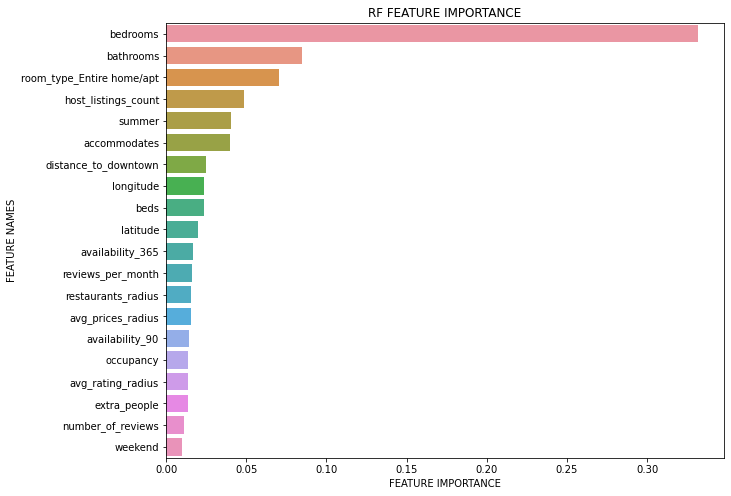

In [70]:
# Let's plot it
_ =plot_feature_importance(rf3.feature_importances_,X_train[old_features+new_features].columns,'RF',20)

### 8.3.4 - RF best features with created features.   
Now let's try to get a subset of features using best features in RF to see if we diminish factors like overfitting.  

In [71]:
best_20_features_nf = get_best_features(rf3.feature_importances_,X_train[old_features+new_features].columns,'RF',20)

In [72]:
rf4 = RandomForestRegressor()
rf4.fit(X_train[best_20_features_nf],y_train)
y_preds = rf4.predict(X_val[best_20_features_nf])
print('Output of Metrics for Random Forest.')
print('(with created features)\n')
model_output(y_val,y_preds)

Output of Metrics for Random Forest.
(with created features)

R^2:  0.7050226620030244
MSE:  2846.4994732681707
MAE:  34.00451581434481
MAPE:  0.2464757934687639


With these features we made the model worst but not by much. Considering we only used 20 features it's not bad.

## 8.4 - Catboost

### 8.4.1 - Catboost with 20 best features.

In [74]:
cb1 = CatBoostRegressor(verbose=False)
cb1.fit(X_train[old_features],y_train)
best_20_features_cb = get_best_features(cb1.feature_importances_,X_train[old_features].columns,'CB',20)
cb1.fit(X_train[best_20_features_cb],y_train)
y_preds = cb1.predict(X_val[best_20_features_cb])
print('Output of Metrics for CatBoost model with best 20 features.')
print('(without created features)\n')
model_output(y_val,y_preds)

Output of Metrics for CatBoost model with best 20 features.
(without created features)

R^2:  0.696808516204102
MSE:  2925.7650936332857
MAE:  34.57751985846057
MAPE:  0.24051042947533496


Just with 20 best features, Catboost does very good compared with our previous models.

### 8.4.2 - Catboost with all features not created.

In [75]:
cb2 = CatBoostRegressor(verbose=False)
cb2.fit(X_train[old_features],y_train)
y_preds = cb2.predict(X_val[old_features])
print('Output of Metrics for CatBoost model.')
print('(without created features)\n')
model_output(y_val,y_preds)

Output of Metrics for CatBoost model.
(without created features)

R^2:  0.690646171556778
MSE:  2985.231054346799
MAE:  34.757081868947886
MAPE:  0.24312989811467134


Very interesting that CatBoost with all of the features (except the ones we created) didn't improve much over the 20  
best features.

### 8.4.3 - Catboost including created features.

In [76]:
cb3 = CatBoostRegressor(verbose=False)
cb3.fit(X_train[old_features + new_features],y_train)
y_preds = cb3.predict(X_val[old_features + new_features])
print('Output of Metrics for Catboost including created features.')
print('(with created features)\n')
model_output(y_val,y_preds)

Output of Metrics for Catboost including created features.
(with created features)

R^2:  0.7505438813772496
MSE:  2407.224619643362
MAE:  30.79418419593001
MAPE:  0.2189142711663927


We see that including the created features we increased the R2 by almost 6%.

### 8.4.4 - Catboost including created features but with best features.

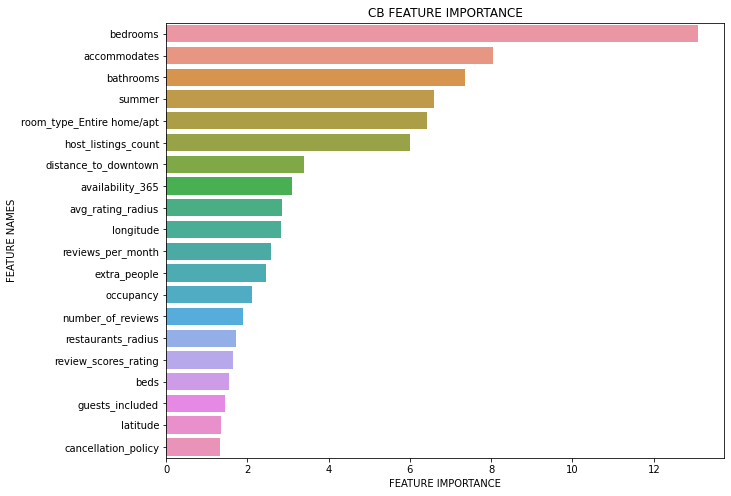

Output of Metrics for Catboost best features.
(with created features)

R^2:  0.7387314769481859
MSE:  2521.2130474110077
MAE:  32.16268662995603
MAPE:  0.23038795671918844


In [77]:
best_20_features_nf_cb = plot_feature_importance(cb3.feature_importances_,X_train[old_features+new_features].columns,'CB',20)
cb4 = CatBoostRegressor(verbose=False)
cb4.fit(X_train[best_20_features_nf_cb],y_train)
y_preds = cb4.predict(X_val[best_20_features_nf_cb])
print('Output of Metrics for Catboost best features.')
print('(with created features)\n')
model_output(y_val,y_preds)

In [78]:
R2 = []
indexes = []
best_r2 = 0
index_best = 0
best_features = []
for index in tqdm_notebook(range(70,86,1)):
    cbc = CatBoostRegressor(verbose=False)
    best_f = get_best_features(cbc.feature_importances_,X_train[old_features+new_features].columns,'CB',index)
    cbc = CatBoostRegressor(verbose=False)
    cbc.fit(X_train[best_f],y_train)
    y_preds = cbc.predict(X_val[best_f])
    r2 = r2_score(y_val,y_preds)
    R2.append(r2)
    indexes.append(index)
    if best_r2 < r2 :
        best_r2 = r2
        index_best = index
        best_features = best_f

  0%|          | 0/16 [00:00<?, ?it/s]

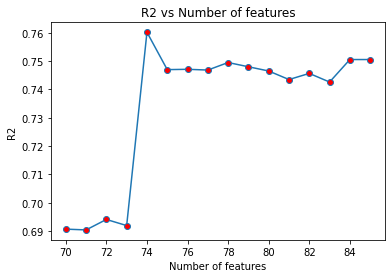

In [79]:
plt.plot(np.array(indexes),np.array(R2),marker='o',markerfacecolor='r')
plt.title('R2 vs Number of features')
plt.xlabel('Number of features')
plt.ylabel('R2')
plt.show()

In [80]:
print(f'The best model had  the best {index_best} features according to Catboost')
print(f'The best R2 score was : {best_r2}')


The best model had  the best 74 features according to Catboost
The best R2 score was : 0.7601740027156649


# 9 - Hyperparameter Tunning

We'll use RandomSearch to check some combination of parameters and see the best option it gives as an output.

In [81]:
cbc = CatBoostRegressor(verbose=False)

param_dist = {'depth'         : [4,5,6,7,8,9, 10],
                 'learning_rate' : [0.01,0.02,0.03,0.04],
                  'iterations'    : [50,100,300,600,1000,2000]
                 }
rscv = RandomizedSearchCV(cbc , param_dist, scoring='r2', cv =5)
rscv.fit(X_train[best_features],y_train)

# Print the tuned parameters and score
print(rscv.best_params_)
print(rscv.best_score_)

{'learning_rate': 0.04, 'iterations': 2000, 'depth': 10}
0.8511139691334574


In [84]:
cb_final = CatBoostRegressor(verbose=False,**rscv.best_params_)
cb_final.fit(X_train[best_features],y_train)
y_preds = cb_final.predict(X_val[best_features])
print('Output of Metrics for Catboost best features .')
print('(with created features and hypertunning)\n')
model_output(y_val,y_preds)

Output of Metrics for Catboost best features .
(with created features and hypertunning)

R^2:  0.7140390550092521
MSE:  2759.4922539431755
MAE:  31.869127983841683
MAPE:  0.22593041835705702
